#### Importación de librerias

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### Carga y formateo de datos

In [3]:
# Carga de datos
piezo_df = pd.read_csv(
    '../data/processed/03_daily/piezo-data_SDH1PS01_daily.csv', 
    parse_dates=['Timestamps'], index_col='Timestamps',
    usecols=['Timestamps', 'depth_m']
)

soil_df = pd.read_csv(
    '../data/processed/03_daily/soil-data_z6-25818_daily.csv', 
    parse_dates=['Timestamps'], index_col='Timestamps',
    usecols=['Timestamps',
             'TEROS12_15cm_water-content_m3/m3', 'TEROS12_30cm_water-content_m3/m3', 'TEROS12_48cm_water-content_m3/m3',
             'TEROS12_15cm_soil-temperature_degree_C', 'TEROS12_30cm_soil-temperature_degree_C', 'TEROS12_48cm_soil-temperature_degree_C']
)

# Diccionarios de mapeo para limpiar nombres y extraer metadatos
soil_rename_map = {
    'TEROS12_15cm_water-content_m3/m3': 'Suelo_15cm_Contenido-agua',
    'TEROS12_30cm_water-content_m3/m3': 'Suelo_30cm_Contenido-agua',
    'TEROS12_48cm_water-content_m3/m3': 'Suelo_48cm_Contenido-agua',
    'TEROS12_15cm_soil-temperature_degree_C': 'Suelo_15cm_Temperatura',
    'TEROS12_30cm_soil-temperature_degree_C': 'Suelo_30cm_Temperatura',
    'TEROS12_48cm_soil-temperature_degree_C': 'Suelo_48cm_Temperatura'
}

# Renombrado de columnas
soil_df = soil_df.rename(columns=soil_rename_map)
piezo_df = piezo_df.rename(columns={'depth_m': 'Piezometro_NA_Profundidad-nivel-freatico'})

# Union de datasets en formato ancho
wide_df = pd.merge(piezo_df, soil_df, left_index=True, right_index=True, how='inner')

In [4]:
# Transformacion de datos a formato largo
long_df = wide_df.reset_index().melt(id_vars='Timestamps', var_name='metadata', value_name='Valor')

# Extraccion de metadatos dividiendo el string por guiones bajos (estructura: sensor_profundidad_variable)
metadata_split = long_df['metadata'].str.split('_', expand=True)
long_df['Sensor'] = metadata_split[0]           # Ej: Suelo, Piezometro
long_df['Profundidad'] = metadata_split[1]      # Ej: 15cm, 30cm, NA
long_df['Variable'] = metadata_split[2]         # Ej: Contenido-agua, Temperatura
long_df = long_df.drop('metadata', axis=1)

# Generacion de un espacio entre el numero y la unidad para etiquetas
long_df['Profundidad'] = long_df['Profundidad'].str.replace('cm', ' cm').replace('NA', 'NA')

# Diccionario con nombres de variables para etiquetas de los graficos
variable_labels = {
    'Profundidad-nivel-freatico': 'Prof. del nivel freático (m)',
    'Contenido-agua': 'Contenido de agua (m³/m³)',
    'Temperatura': 'Temperatura (°C)'
}
# Mapeo de nombres de variables limpios
long_df['Variable'] = long_df['Variable'].map(variable_labels)

# Definicion de orden para las profundidades en la leyenda
soil_depth_order = ['15 cm', '30 cm', '48 cm']
full_depth_order = ['15 cm', '30 cm', '48 cm', 'NA']

#### Definición de estilo de gráficos

In [5]:
# Configuración de estilo
sns.set_theme(style="ticks", context="notebook", font_scale=1)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['figure.figsize'] = (12, 8)

# Configuracion de paleta de colores
viridis_colors = sns.color_palette("viridis_r", n_colors=3)
palette_dict = {
    '15 cm': viridis_colors[0], # Más claro (verde claro)
    '30 cm': viridis_colors[1], # Medio (verde azulado)
    '48 cm': viridis_colors[2], # Más oscuro (morado)
    'NA': 'black'               # Negro
}

#### Series temporales

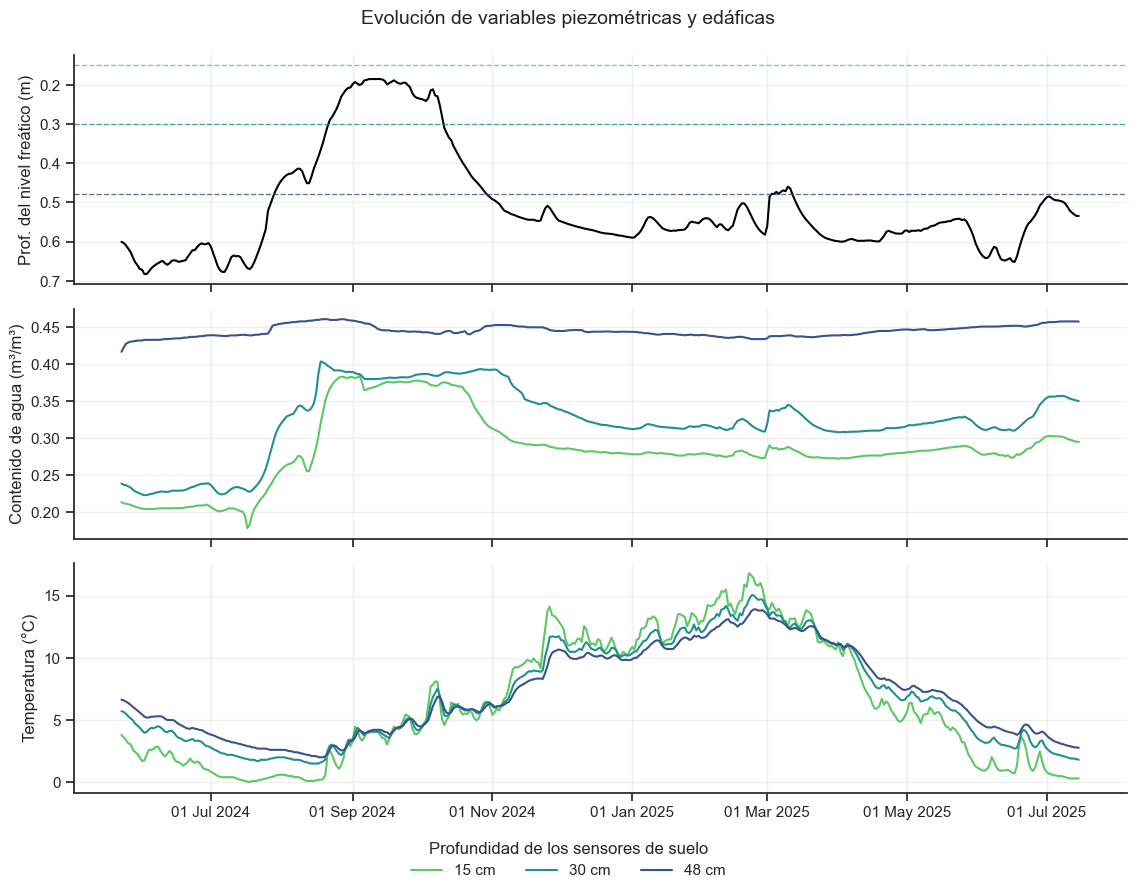

In [6]:
# Generacion de la figura base usando relplot
g = sns.relplot(
    data=long_df,
    x='Timestamps',
    y='Valor',
    row='Variable',      # Crea una fila por cada variable
    hue='Profundidad',   # Diferencia colores según profundidad
    kind='line',
    palette=palette_dict,
    hue_order=full_depth_order,
    height=3,
    aspect=3.5,
    facet_kws={'sharey': False, 'sharex': True} # Eje X compartido, Eje Y independiente
)

# Personalización de ejes y paneles
g.set_titles("")  # Elimina los títulos sobre cada panel
g.set_xlabels("") # Elimina la etiqueta del eje X

# Iteracion sobre cada panel (subplot) para aplicar estilos específicos
for i, (ax, title) in enumerate(zip(g.axes.flat, g.row_names)):
    # Etiqueta del eje y
    ax.set_ylabel(title, fontweight='normal')
    
    # Configuración específica para el primer panel
    if 'Prof. del nivel freático (m)' in title:
        ax.invert_yaxis() # Invertir eje
        
        # Dibuja líneas de referencia horizontales para la ubicación de sensores
        sensor_depths_m = [0.15, 0.30, 0.48]
        sensor_labels = ['15 cm', '30 cm', '48 cm']
        
        for d_m, lbl in zip(sensor_depths_m, sensor_labels):
            # Línea punteada del color correspondiente al sensor
            ax.axhline(y=d_m, color=palette_dict[lbl], linestyle='--', linewidth=1, alpha=0.8)

    # Formato de fecha en el eje X
    date_fmt = mdates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_fmt)


# Personalización de la leyenda
# Extraer los objetos (handles) y etiquetas actuales del primer gráfico
handles, labels = g.axes[0,0].get_legend_handles_labels()

# Filtrar la lista para excluir 'NA'
clean_handles = [h for h, l in zip(handles, labels) if l != 'NA']
clean_labels = [l for l in labels if l != 'NA']

# Elimina la leyenda por defecto
g._legend.remove()

# Creacion de una nueva leyenda
g.fig.legend(
    clean_handles, 
    clean_labels, 
    loc='lower center', 
    bbox_to_anchor=(0.5, 0),
    ncol=3,
    title="Profundidad de los sensores de suelo",
    frameon=False
)

# Ajustes finales
# Título principal de la figura
g.fig.suptitle("Evolución de variables piezométricas y edáficas", x=0.5, y=0.98, fontsize=14)
# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.11) # Ajusta espacio disponible para subplots

plt.show()

#### Gráficos de dispersión

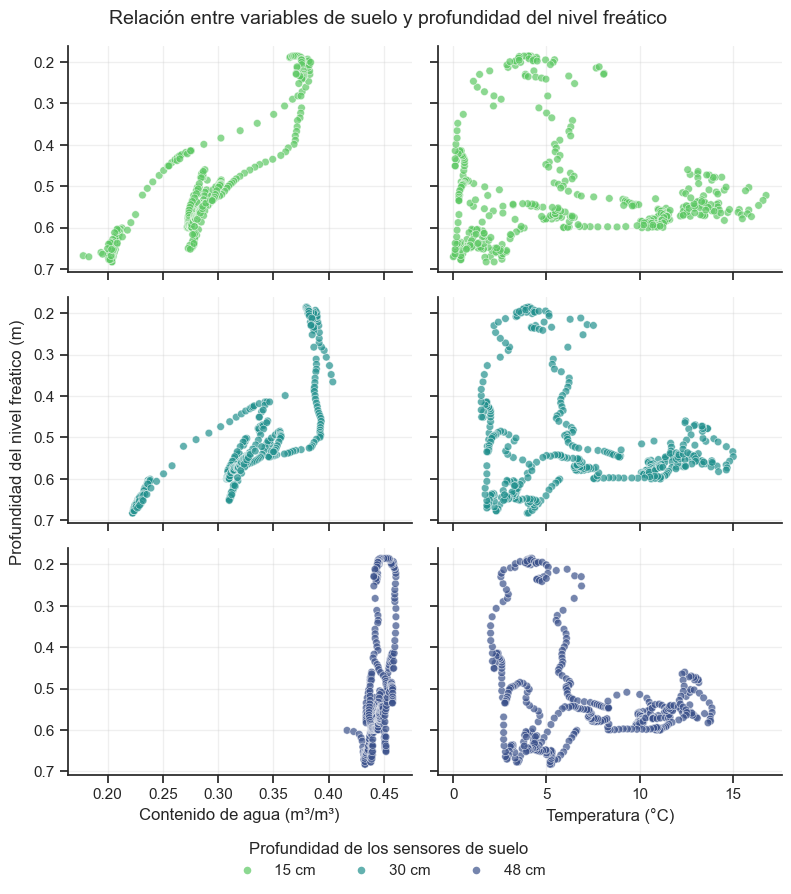

In [7]:
# Preparación de datos para scatter plot
# Filtrado de los datos de suelo
only_soil_long_df = long_df[long_df['Sensor'] == 'Suelo'].copy()

# Extraccion de la serie de nivel freático y conversion a una columna
piezo_col = long_df[long_df['Profundidad'] == 'NA'].set_index('Timestamps')['Valor']

# Union por fecha
scatter_df = only_soil_long_df.merge(piezo_col.rename('GWD'), left_on='Timestamps', right_index=True)

# Generacion de la figura base usando relplot scatter
g2 = sns.relplot(
    data=scatter_df,
    x='Valor',                  # Eje X: Variables de suelo
    y='GWD',                    # Eje Y: Nivel freático
    row='Profundidad',          # Filas: Profundidad (15, 30, 48)
    col='Variable',             # Columnas: Variable (Contenido-agua, Temperatura)
    hue='Profundidad',
    kind='scatter',
    palette=palette_dict,
    row_order=soil_depth_order,
    hue_order=soil_depth_order,
    height=3,
    aspect=1.2,
    facet_kws={'sharey': True, 'sharex': 'col'}, 
    alpha=0.7,
    s=30
)

# Personalización de ejes y paneles
g2.set_titles("") 

# Inversión del eje Y
# Calcula min y max de los datos para establecer los límites manualmente
y_min = scatter_df['GWD'].min()
y_max = scatter_df['GWD'].max()
padding = (y_max - y_min) * 0.05 # Agregar un 5% de espacio
g2.set(ylim=(y_max + padding, y_min - padding))

# Configuracion de etiquetas del eje X en la fila inferior
g2.set_xlabels("")
g2.axes[-1, 0].set_xlabel("Contenido de agua (m³/m³)")
g2.axes[-1, 1].set_xlabel("Temperatura (°C)")

# Etiqueta Global del Eje Y
g2.set_ylabels("")
g2.fig.supylabel(
    "Profundidad del nivel freático (m)", 
    x=0.04, 
    size=plt.rcParams['axes.labelsize'], # Igualar tamaño al eje X
)

# Personalización de la leyenda
# Extraer handles/labels del primer panel
handles, labels = g2.axes[0,0].get_legend_handles_labels()

# Eliminar la leyenda automática
g2._legend.remove()

# Creacion de leyenda personalizada
g2.fig.legend(
    handles=handles,
    labels=labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0), 
    ncol=3,
    title="Profundidad de los sensores de suelo",
    frameon=False
)

# Ajustes finales
# Título principal
g2.fig.suptitle("Relación entre variables de suelo y profundidad del nivel freático", y=0.98, fontsize=14)

# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.13, left=0.11) # Ajusta espacio disponible para subplots

plt.show()

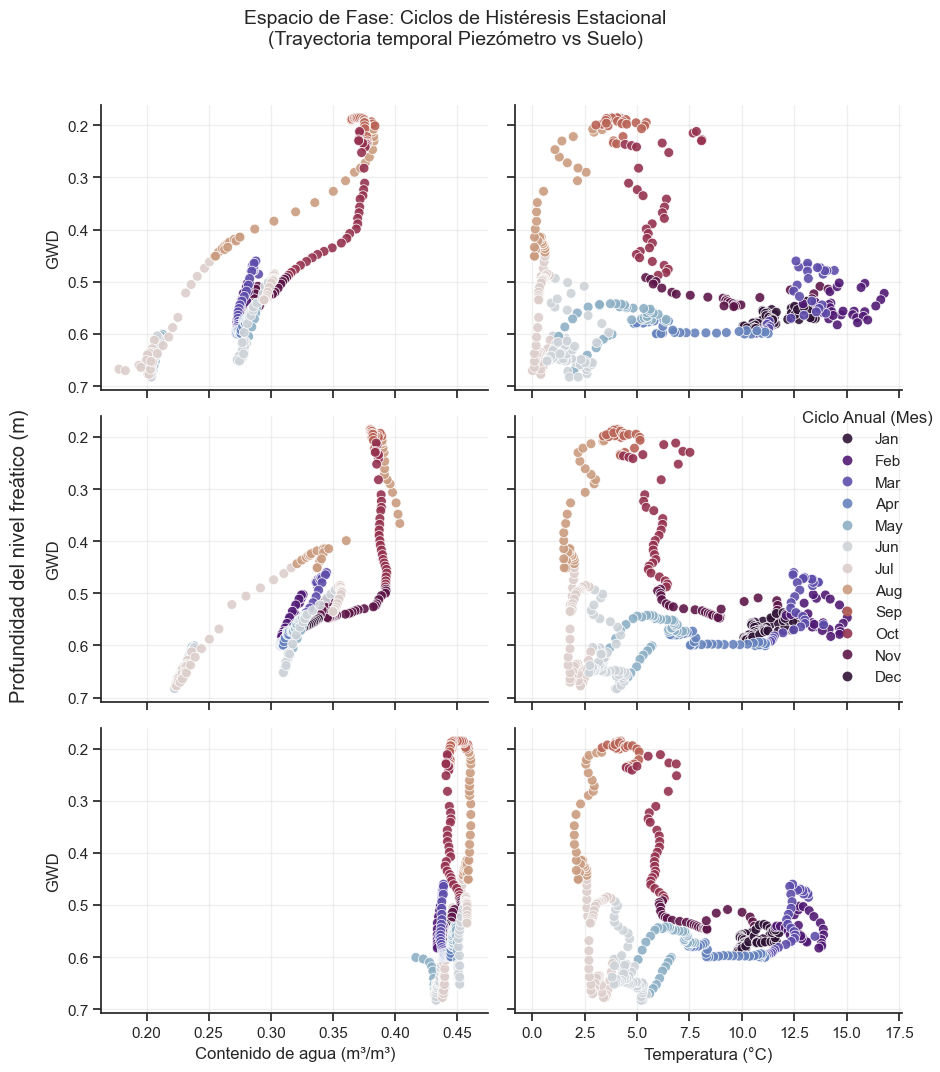

In [8]:
# --- Preparación de datos para el espacio de fase ---
# Creamos una copia para no modificar el original
phase_df = scatter_df.copy()

phase_df = phase_df.set_index('Timestamps')

# Extraemos el mes numérico para la paleta de colores cíclica
phase_df['Mes_Num'] = phase_df.index.month
# Ordenamos por fecha para asegurar que la línea conecte correctamente la secuencia temporal
phase_df = phase_df.sort_index()

# --- Generación del Gráfico ---
# Usamos relplot para crear la estructura de facetas
g_phase = sns.relplot(
    data=phase_df,
    x='Valor', 
    y='GWD',
    row='Profundidad', 
    col='Variable',
    hue='Mes_Num',           # El color indica el mes
    kind='scatter',          # Puntos principales
    palette='twilight_shifted',      # Paleta cíclica (ideal para ciclos anuales: invierno-verano-invierno)
    row_order=soil_depth_order,
    height=3.5, 
    aspect=1.2,
    facet_kws={'sharey': True, 'sharex': 'col'},
    s=50,                    # Tamaño del punto
    alpha=0.9,               # Transparencia para ver superposiciones
    legend='full'            # Mantenemos leyenda para editarla luego
)

# --- Añadir la "Trayectoria" (Línea conectora) ---
# Esto es clave para visualizar la histéresis (el orden de los eventos)
# Usamos map_dataframe para dibujar una línea gris suave en cada subgráfico
def plot_trajectory(x, y, **kwargs):
    plt.plot(x, y, color='gray', linewidth=0.8, alpha=0.4, zorder=0)

#g_phase.map_dataframe(plot_trajectory, x='Valor', y='GWD')

# --- Personalización ---
g_phase.set_titles("") 

# Invertir eje Y (Profundidad) y dar margen
y_min, y_max = phase_df['GWD'].min(), phase_df['GWD'].max()
padding = (y_max - y_min) * 0.05
g_phase.set(ylim=(y_max + padding, y_min - padding))

# Etiquetas de los ejes
g_phase.set_xlabels("")
g_phase.axes[-1, 0].set_xlabel("Contenido de agua (m³/m³)")
g_phase.axes[-1, 1].set_xlabel("Temperatura (°C)")
g_phase.fig.supylabel("Profundidad del nivel freático (m)", x=0.02)

# Ajuste de la Barra de Color / Leyenda
# Reemplazamos la leyenda numérica por nombres de meses abreviados
try:
    # Obtener la leyenda actual
    leg = g_phase._legend
    if leg:
        leg.set_title("Ciclo Anual (Mes)")
        # Diccionario para mapear números a nombres
        import calendar
        month_names = {str(i): calendar.month_abbr[i] for i in range(1, 13)}
        for t in leg.texts:
            if t.get_text() in month_names:
                t.set_text(month_names[t.get_text()])
        # Mover la leyenda fuera de la trama
        g_phase._legend.set_bbox_to_anchor((1.02, 0.5))
except Exception as e:
    print(f"Nota: Ajuste de leyenda omitido ({e})")

# Título
g_phase.fig.suptitle(
    "Espacio de Fase: Ciclos de Histéresis Estacional\n(Trayectoria temporal Piezómetro vs Suelo)", 
    y=1.02, fontsize=14
)

plt.tight_layout()
plt.show()

#### Hovmoller

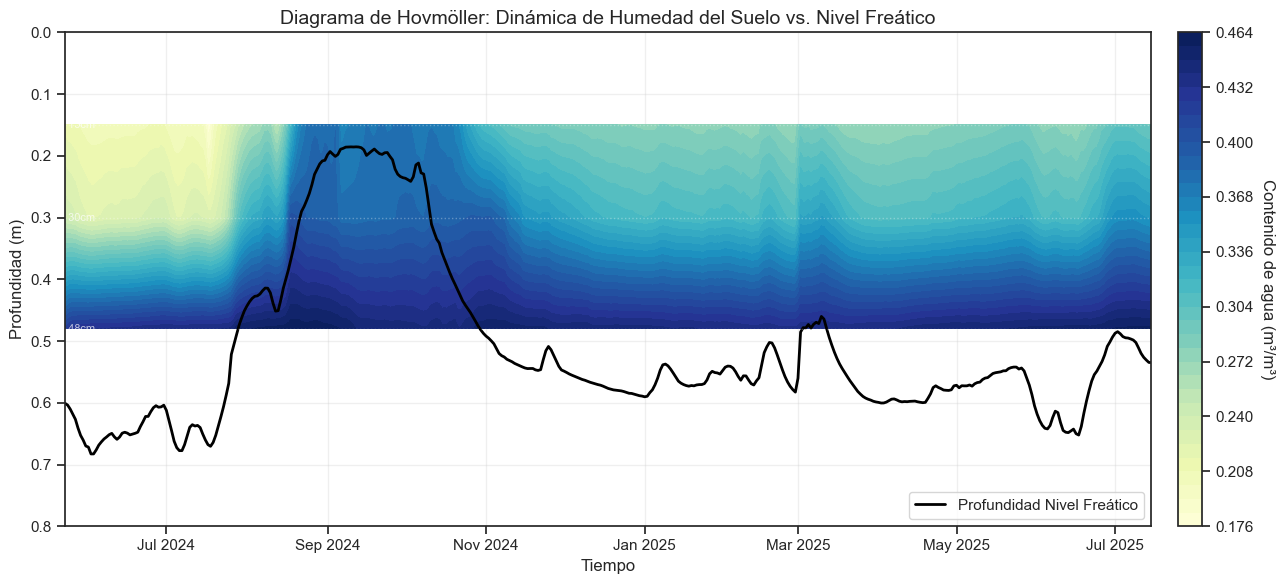

In [16]:
# --- Preparación de datos para el Diagrama de Hovmöller ---
import numpy as np

# 1. Seleccionar datos de humedad y organizarlos en una matriz (Profundidad x Tiempo)
soil_cols_wc = [
    'Suelo_15cm_Contenido-agua', 
    'Suelo_30cm_Contenido-agua', 
    'Suelo_48cm_Contenido-agua'
]

# Extraer solo los datos de suelo y transponer para que el índice sea la profundidad
# (Las filas serán profundidades, las columnas serán las fechas)
soil_matrix = wide_df[soil_cols_wc].T

# Asignar profundidades numéricas (en metros) al índice para poder interpolar
# 15cm -> 0.15m, 30cm -> 0.30m, 48cm -> 0.48m
soil_matrix.index = [0.15, 0.30, 0.48]

# 2. Crear una grilla de profundidad más fina para la interpolación
# Vamos de 0.15m a 0.48m con pasos de 1cm (0.01m)
fine_depths = np.arange(0.15, 0.49, 0.01)

# Reindexar la matriz incluyendo las nuevas profundidades y ordenar
# Esto crea filas vacías (NaN) entre las profundidades originales
soil_matrix_expanded = soil_matrix.reindex(soil_matrix.index.union(fine_depths)).sort_index()

# Interpolar los valores NaN verticalmente (a lo largo del índice de profundidad) para cada día
# 'method="index"' usa los valores numéricos del índice para una interpolación lineal precisa
soil_matrix_interp = soil_matrix_expanded.interpolate(method='index')

# Filtrar para quedarse solo con la grilla fina (para limpiar el índice)
soil_heatmap_data = soil_matrix_interp.loc[fine_depths]

# --- Generación del Gráfico ---
fig, ax = plt.subplots(figsize=(14, 6))

# 3. Dibujar el Mapa de Calor (Contourf)
# X = Fechas, Y = Profundidades, Z = Humedad
# Usamos meshgrid para las coordenadas X e Y
X, Y = np.meshgrid(mdates.date2num(soil_heatmap_data.columns), soil_heatmap_data.index)
# Graficar contornos rellenos
c = ax.contourf(
    soil_heatmap_data.columns, # Eje X: Fechas
    soil_heatmap_data.index,   # Eje Y: Profundidad suelo
    soil_heatmap_data.values,  # Eje Z: Humedad
    levels=40,                 # Número de niveles de color
    cmap='YlGnBu'              # Paleta de colores (Tierra/Agua)
)

# Barra de color
cbar = fig.colorbar(c, ax=ax, pad=0.02)
cbar.set_label('Contenido de agua (m³/m³)', rotation=270, labelpad=15)

# 4. Superponer el Nivel Freático
# Se grafica en negro para contrastar
ax.plot(
    wide_df.index, 
    wide_df['Piezometro_NA_Profundidad-nivel-freatico'], 
    color='black', 
    linewidth=2, 
    linestyle='-', 
    label='Profundidad Nivel Freático'
)

# --- Personalización del Gráfico ---
# Invertir eje Y para que 0 (superficie) esté arriba
# Ajustamos los límites para ver desde la superficie (0) hasta un poco más abajo del sensor más profundo o el NF
ax.set_ylim(0.8, 0.0) 

# Formato de fechas
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_ylabel("Profundidad (m)")
ax.set_xlabel("Tiempo")
ax.set_title("Diagrama de Hovmöller: Dinámica de Humedad del Suelo vs. Nivel Freático", fontsize=14)

# Añadir leyenda para la línea del NF
ax.legend(loc='lower right', frameon=True, facecolor='white', framealpha=0.8)

# Marcar las profundidades reales de los sensores como referencia sutil
for d in [0.15, 0.30, 0.48]:
    ax.axhline(d, color='white', linestyle=':', alpha=0.3, linewidth=1)
    ax.text(wide_df.index[0], d, f' {d*100:.0f}cm', color='white', va='center', fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

#### Correlaciones cruzadas

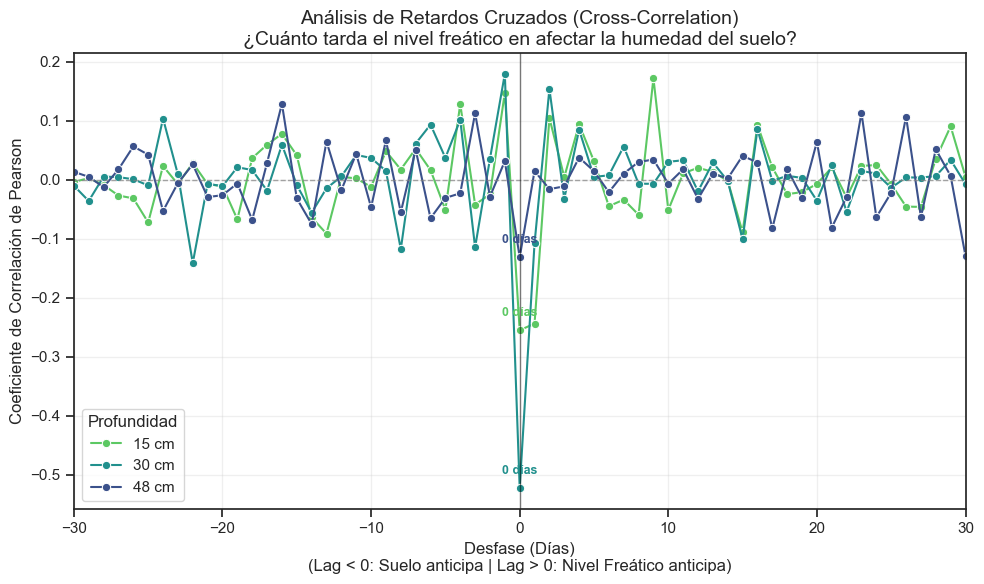

In [10]:
# --- Preparación de datos para Lag Plots ---

# Diferenciacion
wide_df_diff = wide_df.diff().diff().dropna()

# Definimos el rango de lags (días de desfase) a analizar
# Por ejemplo, de -20 a +20 días
lags = np.arange(-30, 31)
lag_data = []

# Nombres de las columnas de interés
target_piezo = 'Piezometro_NA_Profundidad-nivel-freatico'
soil_depths_cols = {
    '15 cm': 'Suelo_15cm_Contenido-agua',
    '30 cm': 'Suelo_30cm_Contenido-agua',
    '48 cm': 'Suelo_48cm_Contenido-agua'
}

# Calculamos la correlación para cada profundidad y cada lag
for depth_label, col_name in soil_depths_cols.items():
    for lag in lags:
        # Calculamos la correlación entre el Piezómetro y la Humedad desplazada
        # shift(lag): desplaza la serie de humedad 'lag' días
        # Si lag > 0, comparamos Piezómetro(t) con Humedad(t + lag) -> Efecto futuro
        corr = wide_df_diff[target_piezo].corr(wide_df_diff[col_name].shift(lag))
        
        lag_data.append({
            'Profundidad': depth_label,
            'Lag (Días)': lag,
            'Correlación': corr
        })

# Convertimos a DataFrame para facilitar el ploteo con Seaborn
lag_df = pd.DataFrame(lag_data)

# --- Generación del Gráfico ---
plt.figure(figsize=(10, 6))

# Usamos lineplot para ver la evolución de la correlación
sns.lineplot(
    data=lag_df,
    x='Lag (Días)',
    y='Correlación',
    hue='Profundidad',
    palette=palette_dict, # Usamos la misma paleta que definiste antes
    marker='o',           # Marcadores para identificar cada día
    markersize=6
)

# --- Añadir líneas de referencia ---
plt.axhline(0, color='grey', linestyle='--', linewidth=1, alpha=0.7) # Línea cero
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5) # Día 0 (Sin desfase)

# Identificar y marcar el pico máximo de correlación para cada profundidad
# Esto ayuda a ver visualmente el "tiempo de respuesta"
for depth in soil_depths_cols.keys():
    subset = lag_df[lag_df['Profundidad'] == depth]
    # Buscar el lag con la máxima correlación absoluta (puede ser negativa o positiva)
    # Aquí asumimos interés en la correlación más fuerte
    max_idx = subset['Correlación'].abs().idxmax()
    max_point = subset.loc[max_idx]
    
    # Anotar en el gráfico
    plt.annotate(
        f"{int(max_point['Lag (Días)'])} días",
        xy=(max_point['Lag (Días)'], max_point['Correlación']),
        xytext=(0, 10), textcoords='offset points',
        ha='center', fontsize=9, fontweight='bold',
        color=palette_dict[depth]
    )

# --- Personalización ---
plt.title("Análisis de Retardos Cruzados (Cross-Correlation)\n¿Cuánto tarda el nivel freático en afectar la humedad del suelo?", fontsize=14)
plt.xlabel("Desfase (Días)\n(Lag < 0: Suelo anticipa | Lag > 0: Nivel Freático anticipa)")
plt.ylabel("Coeficiente de Correlación de Pearson")
plt.grid(True, alpha=0.3)
plt.xlim(lags.min(), lags.max())

plt.tight_layout()
plt.show()

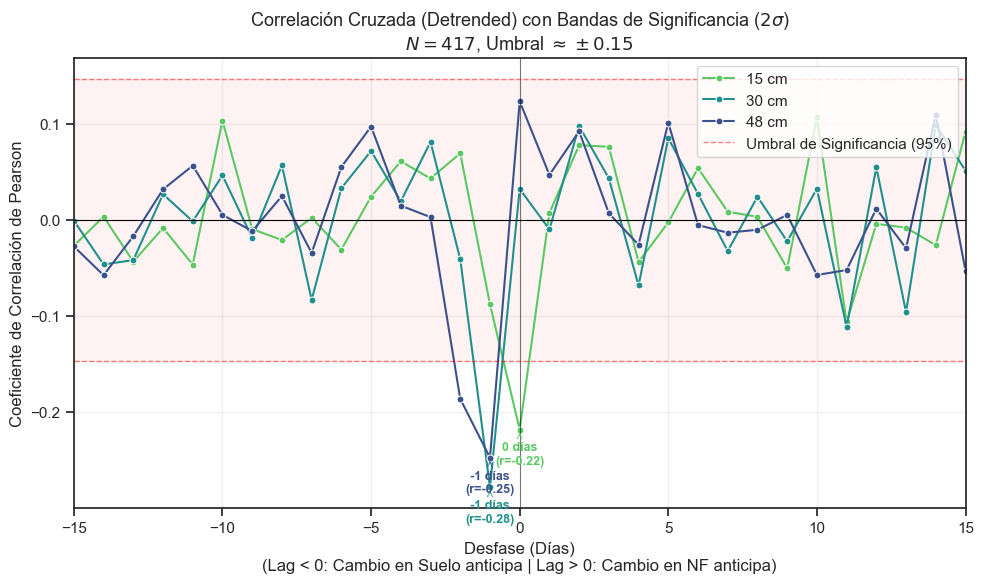

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Detrending: Diferenciación de Primer Orden ---
# Eliminamos la tendencia estacional para ver la interacción hidrodinámica pura
wide_df_diff = wide_df.diff().diff().dropna()

# Calculamos N (número de muestras) para el umbral de significancia
n_samples = len(wide_df_diff)
# Umbral de significancia (aprox. 2 desviaciones estándar o 95% de confianza)
# Si la correlación está dentro de estas bandas, se considera ruido (correlación = 0)
significance_threshold = 3 / np.sqrt(n_samples)

# --- 2. Cálculo de Correlaciones con Lags ---
lags = np.arange(-15, 16)
lag_data_diff = []

target_piezo = 'Piezometro_NA_Profundidad-nivel-freatico'
soil_depths_cols = {
    '15 cm': 'Suelo_15cm_Temperatura',
    '30 cm': 'Suelo_30cm_Temperatura',
    '48 cm': 'Suelo_48cm_Temperatura'
}

for depth_label, col_name in soil_depths_cols.items():
    for lag in lags:
        # Correlación sobre datos diferenciados
        corr = wide_df_diff[target_piezo].corr(wide_df_diff[col_name].shift(lag))
        
        lag_data_diff.append({
            'Profundidad': depth_label,
            'Lag (Días)': lag,
            'Correlación': corr
        })

lag_df_diff = pd.DataFrame(lag_data_diff)

# --- 3. Generación del Gráfico ---
plt.figure(figsize=(10, 6))

# Graficar las curvas
sns.lineplot(
    data=lag_df_diff,
    x='Lag (Días)',
    y='Correlación',
    hue='Profundidad',
    palette=palette_dict,
    marker='o',
    markersize=5,
    linewidth=1.5
)

# --- Elementos de Referencia Estadística ---
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Dibujar las bandas de significancia (2 desviaciones estándar)
plt.axhline(significance_threshold, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Umbral de Significancia (95%)')
plt.axhline(-significance_threshold, color='red', linestyle='--', linewidth=1, alpha=0.5)
# Rellenar la zona de "no significancia" (ruido)
plt.fill_between([lags.min(), lags.max()], -significance_threshold, significance_threshold, color='red', alpha=0.05)


# --- Anotación Condicional (Solo si es Significativa) ---
for depth in soil_depths_cols.keys():
    subset = lag_df_diff[lag_df_diff['Profundidad'] == depth]
    # Encontrar el pico máximo (absoluto)
    max_idx = subset['Correlación'].abs().idxmax()
    max_point = subset.loc[max_idx]
    
    # CRITERIO: Solo anotamos si el valor absoluto supera el umbral de 2 sigmas
    if abs(max_point['Correlación']) > significance_threshold:
        plt.annotate(
            f"{int(max_point['Lag (Días)'])} días\n(r={max_point['Correlación']:.2f})",
            xy=(max_point['Lag (Días)'], max_point['Correlación']),
            xytext=(0, 20 if max_point['Correlación'] > 0 else -25), # Ajustar texto arriba o abajo
            textcoords='offset points',
            ha='center', fontsize=9, fontweight='bold',
            color=palette_dict[depth],
            arrowprops=dict(arrowstyle="->", color=palette_dict[depth], alpha=0.6)
        )

# --- Personalización ---
plt.title(f"Correlación Cruzada (Detrended) con Bandas de Significancia ($2\\sigma$)\n$N={n_samples}$, Umbral $\\approx \\pm {significance_threshold:.2f}$", fontsize=13)
plt.xlabel("Desfase (Días)\n(Lag < 0: Cambio en Suelo anticipa | Lag > 0: Cambio en NF anticipa)")
plt.ylabel("Coeficiente de Correlación de Pearson")
plt.legend(loc='upper right', frameon=True)
plt.grid(True, alpha=0.3)
plt.xlim(lags.min(), lags.max())

plt.tight_layout()
plt.show()

#### Correlaciones cruzadas estacionales?

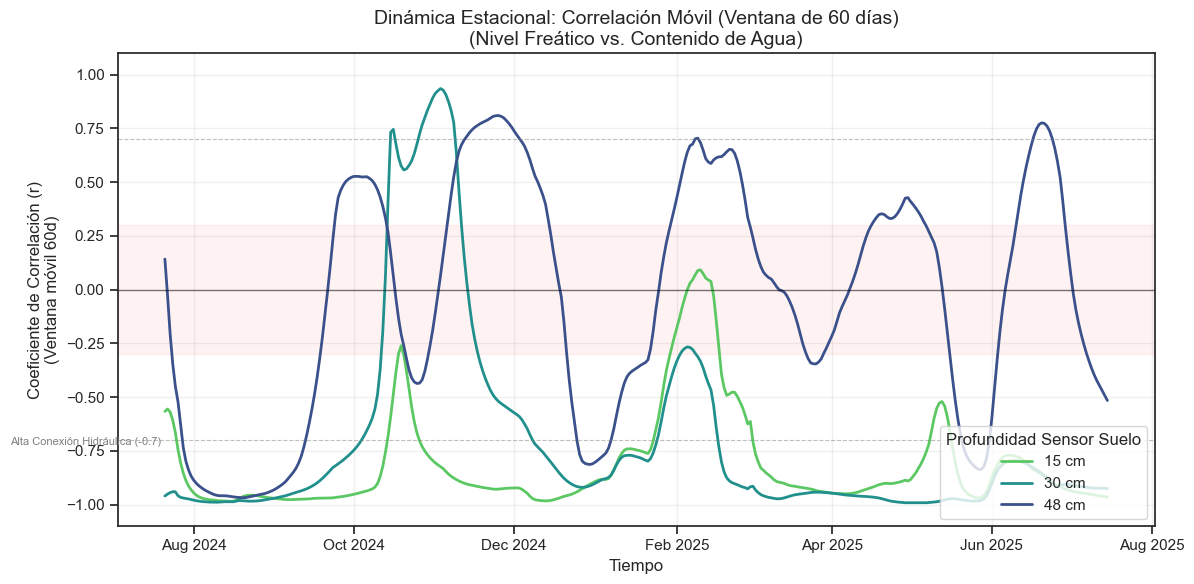

In [12]:
# --- Configuración de la Ventana Móvil ---
# Definimos el tamaño de la ventana en días
# 45 días es un buen balance para capturar tendencias mensuales/estacionales sin demasiado ruido
window_days = 60

# Nombres de las columnas
target_piezo = 'Piezometro_NA_Profundidad-nivel-freatico'
soil_depths_cols = {
    '15 cm': 'Suelo_15cm_Contenido-agua',
    '30 cm': 'Suelo_30cm_Contenido-agua',
    '48 cm': 'Suelo_48cm_Contenido-agua'
}

# --- Cálculo de Correlación Móvil ---
# DataFrame para guardar las series de correlación
rolling_corr_df = pd.DataFrame(index=wide_df.index)

for depth_label, col_name in soil_depths_cols.items():
    # Calculamos la correlación de Pearson en una ventana móvil
    # .rolling(window=X).corr(other) calcula la correlación entre la columna base y 'other' dentro de la ventana
    r_series = wide_df[target_piezo].rolling(window=window_days).corr(wide_df[col_name])
    rolling_corr_df[depth_label] = r_series

# --- Generación del Gráfico ---
plt.figure(figsize=(12, 6))

# Graficar cada profundidad con su color correspondiente
for depth in soil_depths_cols.keys():
    sns.lineplot(
        data=rolling_corr_df,
        x=rolling_corr_df.index,
        y=depth,
        color=palette_dict[depth],
        label=depth,
        linewidth=2
    )

# --- Elementos de Referencia y Estilo ---
# Línea de correlación cero (sin relación)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
# Líneas de correlación fuerte (referencia visual)
plt.axhline(-0.7, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
plt.axhline(0.7, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
plt.text(wide_df.index[0], -0.72, 'Alta Conexión Hidráulica (-0.7)', color='gray', fontsize=8)

# Formato de fechas en eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# Títulos y Etiquetas
plt.title(f"Dinámica Estacional: Correlación Móvil (Ventana de {window_days} días)\n(Nivel Freático vs. Contenido de Agua)", fontsize=14)
plt.ylabel(f"Coeficiente de Correlación (r)\n(Ventana móvil {window_days}d)")
plt.xlabel("Tiempo")
plt.ylim(-1.1, 1.1)  # Rango completo de correlación + margen
plt.legend(title="Profundidad Sensor Suelo", loc='lower right', frameon=True)
plt.grid(True, alpha=0.3)

# Añadir sombreado para zonas de "Desacople" (donde r está cerca de 0)
# Opcional: colorear el fondo donde la correlación es débil (entre -0.3 y 0.3)
plt.axhspan(-0.3, 0.3, color='red', alpha=0.05, label='Zona de Desacople / Ruido')

plt.tight_layout()
plt.show()

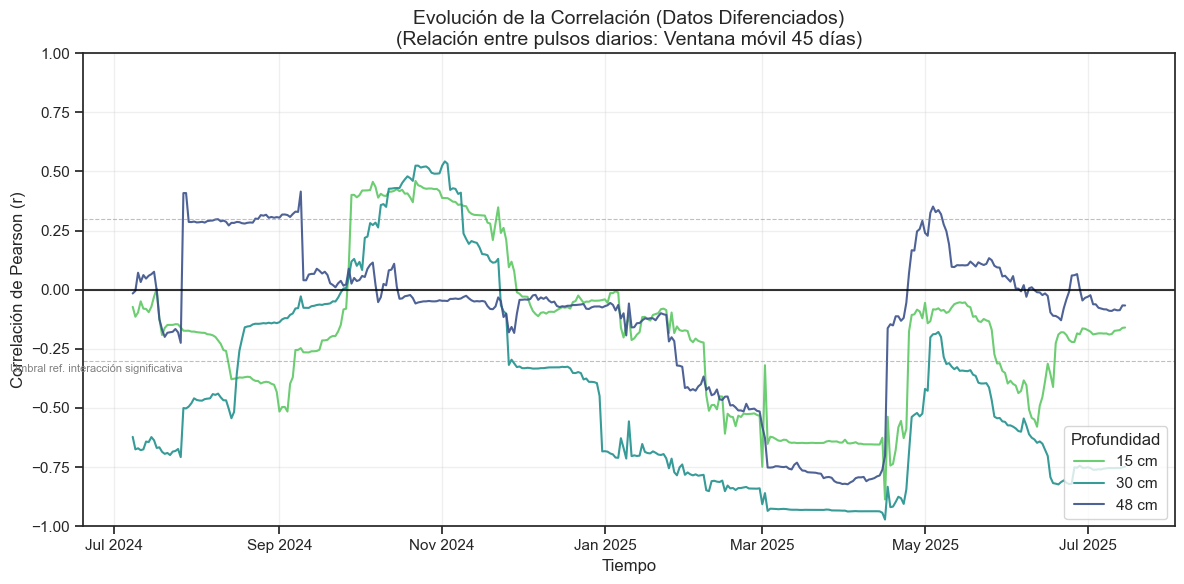

In [13]:
# --- 1. Detrending (Diferenciación) ---
# Calculamos los cambios diarios para eliminar la tendencia estacional
# Esto es vital para que la correlación móvil no esté sesgada por el ciclo invierno/verano
wide_df_diff = wide_df.diff().diff().dropna()

# --- 2. Configuración de la Ventana Móvil ---
# Mantenemos la ventana de 45 días, pero ahora se aplica sobre las diferencias
window_days = 45

# Nombres de las columnas
target_piezo = 'Piezometro_NA_Profundidad-nivel-freatico'
soil_depths_cols = {
    '15 cm': 'Suelo_15cm_Contenido-agua',
    '30 cm': 'Suelo_30cm_Contenido-agua',
    '48 cm': 'Suelo_48cm_Contenido-agua'
}

# --- 3. Cálculo de Correlación Móvil en Datos Diferenciados ---
rolling_corr_diff = pd.DataFrame(index=wide_df_diff.index)

for depth_label, col_name in soil_depths_cols.items():
    # Calculamos la correlación de Pearson en ventana móvil sobre las diferencias
    r_series = wide_df_diff[target_piezo].rolling(window=window_days).corr(wide_df_diff[col_name])
    rolling_corr_diff[depth_label] = r_series

# --- 4. Generación del Gráfico ---
plt.figure(figsize=(12, 6))

# Graficar las series de correlación
for depth in soil_depths_cols.keys():
    sns.lineplot(
        data=rolling_corr_diff,
        x=rolling_corr_diff.index,
        y=depth,
        color=palette_dict[depth],
        label=depth,
        linewidth=1.5,
        alpha=0.9
    )

# --- Elementos de Referencia ---
plt.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.8) # Línea cero más visible

# Umbral de referencia para correlaciones significativas en diferencias (suele ser más bajo, ej: +/- 0.3)
plt.axhline(-0.3, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
plt.axhline(0.3, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
plt.text(wide_df.index[0], -0.35, 'Umbral ref. interacción significativa', color='gray', fontsize=8)

# Formato de fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# Títulos
plt.title(
    f"Evolución de la Correlación (Datos Diferenciados)\n"
    f"(Relación entre pulsos diarios: Ventana móvil {window_days} días)", 
    fontsize=14
)
plt.ylabel(f"Correlación de Pearson (r)")
plt.xlabel("Tiempo")
plt.ylim(-1.0, 1.0)
plt.legend(title="Profundidad", loc='lower right', frameon=True)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Graficos de violin

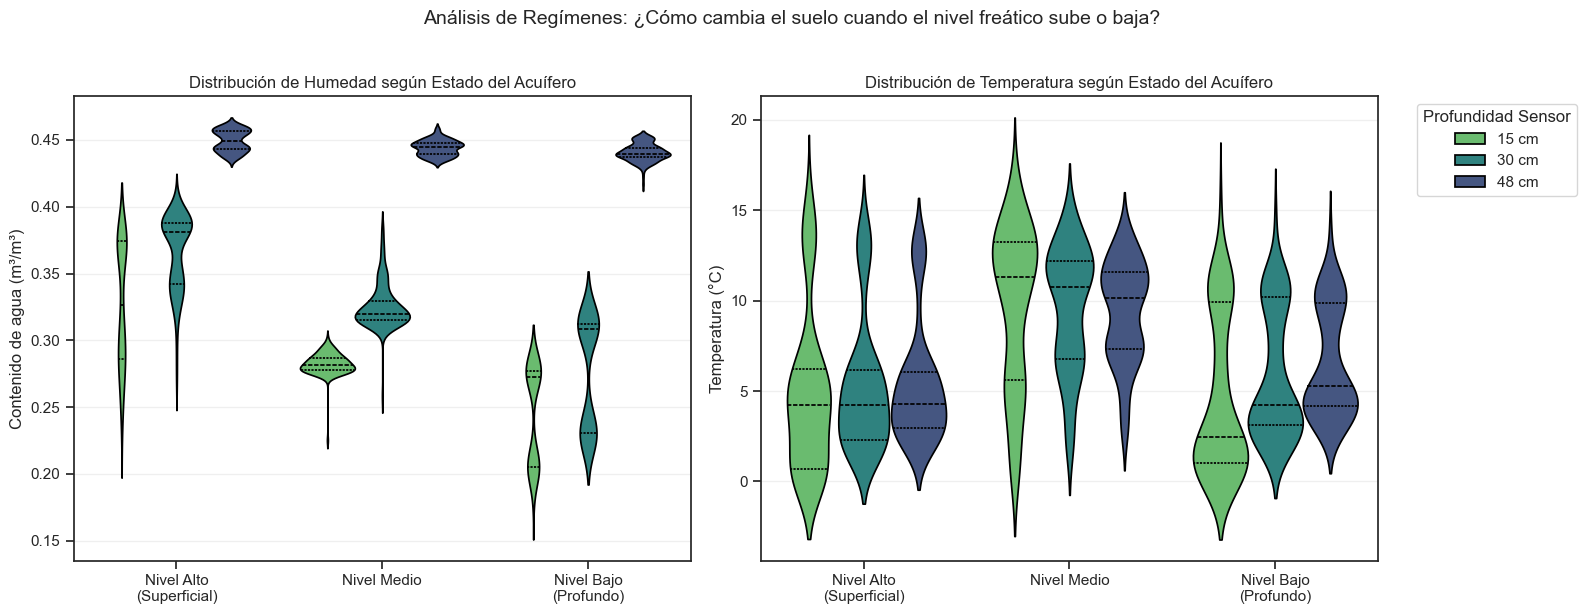

In [14]:
# --- 1. Definición de Regímenes Hidrológicos ---
# Usamos una copia de los datos originales (absolutos) para ver estados físicos
regime_df = wide_df.copy()

# Definimos la columna del piezómetro
piezo_col = 'Piezometro_NA_Profundidad-nivel-freatico'

# Clasificamos la profundidad del NF en 3 categorías (terciles) usando qcut
# NOTA IMPORTANTE: 
# - Valor pequeño de profundidad (ej. 0.2m) = Nivel Freático ALTO (Cerca de superficie)
# - Valor grande de profundidad (ej. 1.0m) = Nivel Freático BAJO (Lejos de superficie)
# Por tanto, el primer tercil (valores bajos) corresponde al Nivel Alto.
labels_regime = ['Nivel Alto\n(Superficial)', 'Nivel Medio', 'Nivel Bajo\n(Profundo)']

regime_df['Regimen_NF'] = pd.qcut(
    regime_df[piezo_col], 
    q=3, 
    labels=labels_regime
)

# --- 2. Preparación de datos (Formato Largo) ---
# Separamos variables de Humedad y Temperatura
cols_wc = [c for c in regime_df.columns if 'Contenido-agua' in c]
cols_temp = [c for c in regime_df.columns if 'Temperatura' in c]

# Función auxiliar para derretir (melt) y limpiar
def melt_regime(df, value_cols, var_name_clean):
    melted = df[value_cols + ['Regimen_NF']].melt(id_vars='Regimen_NF', value_name='Valor')
    # Extraer profundidad (ej. "15 cm") del nombre de la columna
    melted['Profundidad'] = melted['variable'].str.split('_').str[1].str.replace('cm', ' cm')
    melted['Tipo'] = var_name_clean
    return melted

df_wc = melt_regime(regime_df, cols_wc, 'Contenido de Agua')
df_temp = melt_regime(regime_df, cols_temp, 'Temperatura')

# --- 3. Generación de Gráficos (Violin Plots) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Subplot 1: Contenido de Agua ---
sns.violinplot(
    data=df_wc,
    x='Regimen_NF', 
    y='Valor',
    hue='Profundidad',
    palette=palette_dict,
    hue_order=['15 cm', '30 cm', '48 cm'],
    inner="quart", # Dibuja los cuartiles dentro del violín
    ax=axes[0]
)
axes[0].set_title("Distribución de Humedad según Estado del Acuífero", fontsize=12)
axes[0].set_ylabel("Contenido de agua (m³/m³)")
axes[0].set_xlabel("")
axes[0].grid(True, axis='y', alpha=0.3)

# --- Subplot 2: Temperatura ---
sns.violinplot(
    data=df_temp,
    x='Regimen_NF', 
    y='Valor',
    hue='Profundidad',
    palette=palette_dict,
    hue_order=['15 cm', '30 cm', '48 cm'],
    inner="quart",
    ax=axes[1]
)
axes[1].set_title("Distribución de Temperatura según Estado del Acuífero", fontsize=12)
axes[1].set_ylabel("Temperatura (°C)")
axes[1].set_xlabel("")
axes[1].grid(True, axis='y', alpha=0.3)

# Ajustes finales
plt.suptitle("Análisis de Regímenes: ¿Cómo cambia el suelo cuando el nivel freático sube o baja?", fontsize=14, y=1.02)
# Movemos la leyenda para que no estorbe
axes[1].legend(title="Profundidad Sensor", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].get_legend().remove()

plt.tight_layout()
plt.show()